In [1]:
# Manipulación de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Visualización de datos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pylab

import scipy.stats as stats

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# Modelado
# ==============================================================================

from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')

In [3]:
url_train = "https://github.com/PabloJRW/titanic-classifier/raw/main/train.csv"
url_test = "https://github.com/PabloJRW/titanic-classifier/raw/main/test.csv"
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

# <b>EDA (Análisis Exploratorio de Datos) 

In [4]:
 # Dimensión de los datos
df_train.shape

(891, 12)

In [5]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df_train.drop('PassengerId', axis=1, inplace=True)
df_test.drop('PassengerId', axis=1, inplace=True)

# Cambio el nombre de las variables 
df_train.columns = ["vida", "clase", "nombre", "sexo", "edad", "sibsp", "parch", "ticket", "tarifa", "cabina", "puerto"]
df_test.columns = ["clase", "nombre", "sexo", "edad", "sibsp", "parch", "ticket", "tarifa", "cabina", "puerto"]

Los datos contenidos en la variable nombre, tienen la particularidad de que contienen los títulos de cortesía, por ejemplo, Mr, Mrs, Miss, entre otros títulos. Hago la extracción de estos para conocer posteriormente si es un factor predictivo del problema.

In [8]:
# Extracción del título social 
df_train['titulo'] = df_train.nombre.str.extract(' ([A-Za-z]+)\.', expand = False)
df_test['titulo'] = df_test.nombre.str.extract(' ([A-Za-z]+)\.', expand = False)

In [9]:
df_train.head(3)

,vida,clase,nombre,sexo,edad,sibsp,parch,ticket,tarifa,cabina,puerto,titulo
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss


#### <b>Valores nulos

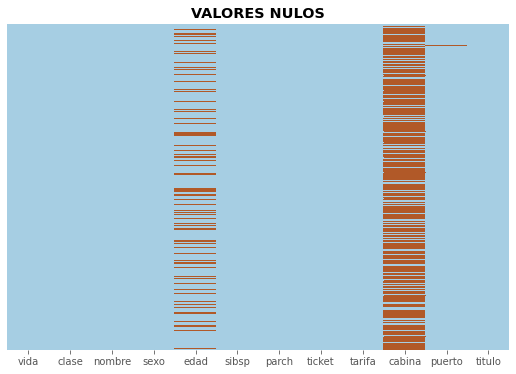

PORCENTAJE DE VALORES NULOS:
edad      19.87
cabina    77.10
puerto     0.22
dtype: float64


In [10]:
# Visualización de variables con valores faltantes
plt.figure(figsize=(9,6))
plt.title('VALORES NULOS', fontweight='bold')
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='Paired')
plt.show()

nulls = df_train.isnull().sum()
print('PORCENTAJE DE VALORES NULOS:')
print('='*64)
print(round(nulls[nulls>0]/len(df_train)*100, 2))

In [11]:
# La variable cabina contiene gran cantidad de valores faltantes por lo que la elimino.
df_train.drop('cabina', axis=1, inplace=True)
df_test.drop('cabina', axis=1, inplace=True)

# Copia de los datasets
df_train = df_train.copy()
df_test = df_test.copy()

## <b>Variable Objetivo

Recordemos que el análisis de los datos aquí aplicado tiene como objetivo encontrar las mejores características predictoras para alimentar un modelo de aprendizaje automático. Por la naturaleza de la variable objetivo (que se busca predecir), podemos determinar que se trata de un problema de clasificación binario. 

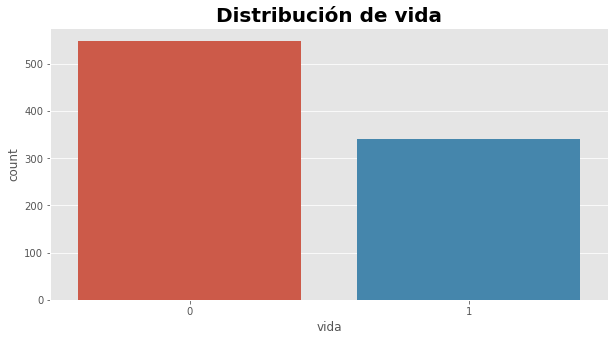

In [12]:
# Distribución de la variable objetivo
plt.figure(figsize=(10, 5))
plt.title('Distribución de vida', fontweight='bold', fontsize=20)
sns.countplot(x=df_train['vida'])
plt.show()

In [13]:
# Cuál fue el porcentaje de sobrevivientes?
print(f"Porcentaje de supervivientes: {round(len(df_train[df_train['vida']==1]) / len(df_train) * 100, 2) }%")
print(f"Porcentaje de muertes: {round(len(df_train[df_train['vida']==0]) / len(df_train) * 100, 2) }%")

Porcentaje de supervivientes: 38.38%
Porcentaje de muertes: 61.62%


## <b>VARIABLES NUMÉRICAS

En este punto procedo al análisis de las variables numéricas.

In [14]:
# Variables numéricas
# ==============================================================================
numeric_features = df_train.select_dtypes(include=["float", "int"]).columns
df_train[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
vida,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
clase,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
edad,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
tarifa,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


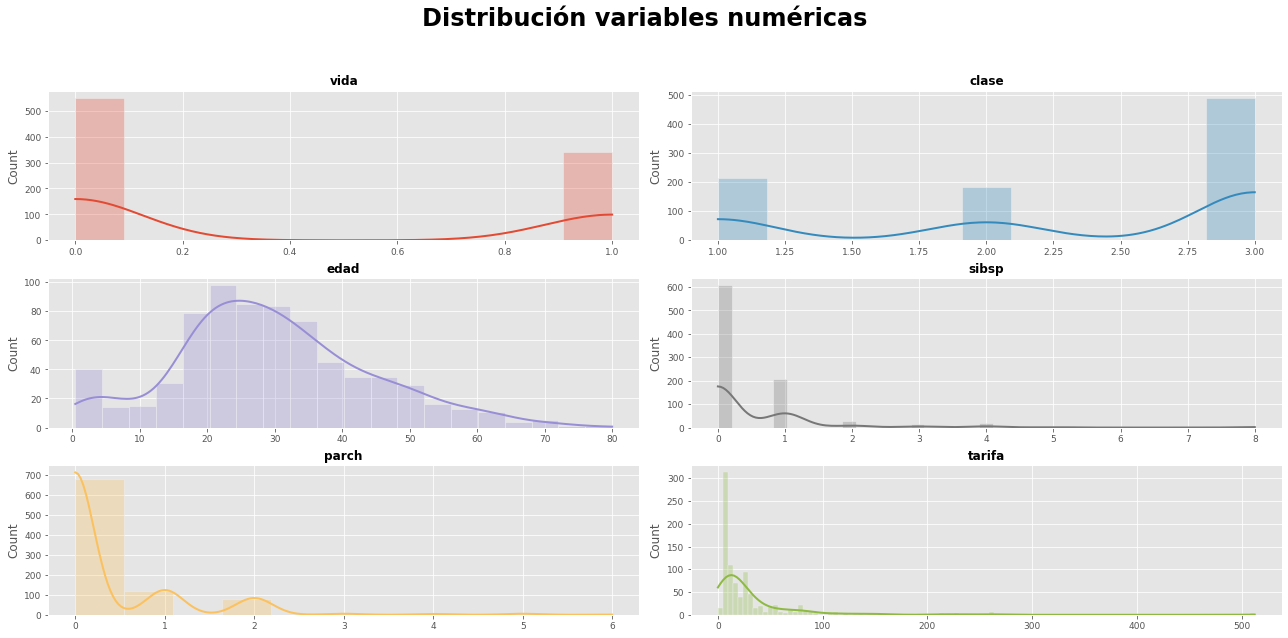

In [15]:
# Gráficos de distribución - Variable numéricas
# ==============================================================================
# Ajustar el número de subplots en función de la cantidad de variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 9))
axes = axes.flat

for i, colum in enumerate(numeric_features):
    sns.histplot(
        x       = df_train[colum].dropna(),
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Distribución variables numéricas', fontsize = 24, fontweight = "bold");

### <b> Edad

<b>Hubo diferencias significativas en cuanto a la edad, en los pasajeros sobrevientes sobre aquellos que fallecieron?. 

De haber diferencias en edades de los pasajeros sobrevivientes y fallecidos, podemos concluir que esta variable nos podría aportar información a nuestro modelo de predicción. De no ser el caso, la excluimos para el mismo.

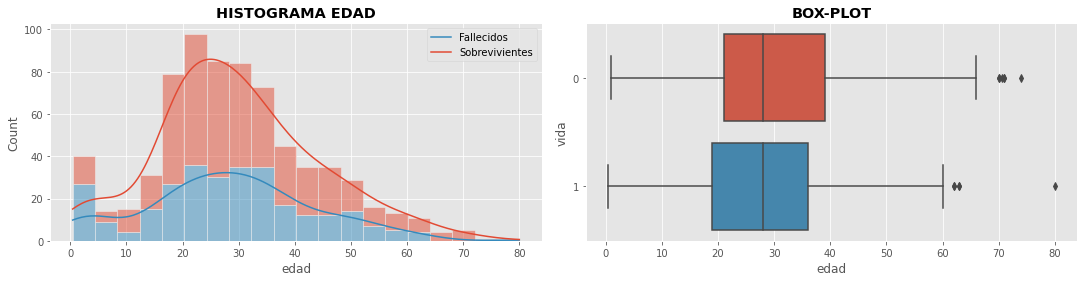

In [16]:
# Gráficas de distribución para la variable edad
# ==============================================================================
fig = plt.figure(figsize=(28,4))
gs = fig.add_gridspec(1,3)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.set_title("HISTOGRAMA EDAD", fontweight='bold')
ax1.set_title("BOX-PLOT", fontweight='bold')

sns.histplot(x='edad', hue='vida', data=df_train, multiple='stack', kde=True, ax=ax0)
ax0.legend(['Fallecidos','Sobrevivientes'])

sns.boxplot(x='edad', y='vida', orient='h', data=df_train, ax=ax1)


fig.subplots_adjust(wspace=0.09)
plt.show()

Aplico la prueba de normalidad a la variable edad mediante el método D'Agostino K-squared. La misma establece como hipótesis nula, que los datos se distribuyen de manera normal. Alpha = 5%

In [17]:
# Prueba de normalidad
k2, p = stats.normaltest(df_train.edad, nan_policy='omit')

print('p-value: {}'.format(p))
if p > 0.05:
    print('No hay evidencias significativas para rechazar la hipótesis nula. Gaussiana')
else:
    print('Hay evidencias significativas para rechazar la hipótesis nula. No Gaussiana')


p-value: 0.00011709599657350744
Hay evidencias significativas para rechazar la hipótesis nula. No Gaussiana


El test de normalidad nos da como resultado un p-valor por debajo del nivel de significancia establecido a priori (0.05), por lo que se podemos concluir, que contamos con las evidencias significativas para rechazar la hipótesis nula de que los datos se distribuyen de manera Gaussiana. 

Realizo una prueba de hipótesis para conocer si hubo diferencia en las edades entre los grupos de pasajeros que sobrevivieron y aquellos que no lo hicieron. Y así, determinar si la variable edad es una característica que nos aporta información a nuestro modelo de predicción.

Antes aplico el análisis de homogeneidad de varianza, para conocer qué prueba de hipótesis conviene más utilizar. 

In [26]:
# División de los grupos de supervivientes y fallecidos
fallecidos = df_train[df_train['vida']==0]    # Grupo de sobrevivientes
sobrevivientes = df_train[df_train['vida']==1] # Grupo de fallecidos

edad_fallecidos, edad_sobrevivientes = fallecidos['edad'], sobrevivientes['edad']

In [62]:
# Levene Test
# ==============================================================================
levene_test = stats.levene(edad_fallecidos, edad_sobrevivientes, center='median')

# Fligner-Killeen test
# ==============================================================================
fligner_test = stats.fligner(edad_fallecidos,  edad_sobrevivientes, center='median')

print(levene_test[1])
print(fligner_test[1])

0.022810547347457587
0.01690660597210018


El test de Levene (utilizando la mediana) y el test de Fligner-Killeen (no paramétrico), muestran evidencias significativas para rechazar la hipótesis nula, de que ambos grupos tienen la misma varianza.  p-valor < 0.05. Es decir, nuestros datos son heterocedásticos.

Una vez conocidas las caracteŕisticas de las muestras en cuestión, la prueba de hipótesis que mejor se ajusta a estas, es la prueba t de Welch.

In [30]:
# Welch's t-test
# ===============================================================================
welch_test = stats.ttest_ind( edad_sobrevivientes, edad_fallecidos, equal_var=False)
print(welch_test[1])

0.05830915997775747


### <b>Tarifa

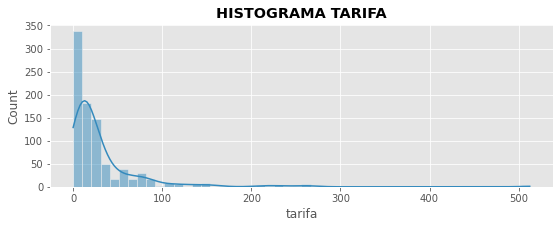

In [61]:
# Gráficas de distribución para la variable tarifa
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,3))

ax.set_title("HISTOGRAMA TARIFA", fontweight='bold')
sns.histplot(x=df_train.tarifa , bins=50, kde=True, ax=ax)

plt.show()

Se puede observar que <b>tarifa</b> tiene una distribución asimetrica y contiene gran cantidad de valores atípicos.

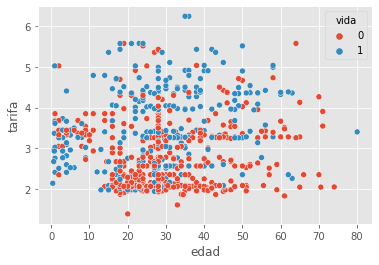

In [59]:
tarifa_log =np.log(df_train['tarifa'])
sns.scatterplot(x=df_train['edad'], y=tarifa_log, hue=df_train['vida'])
plt.show()

## <b>VARIABLES CUALITATIVAS

In [63]:
train = df_train.copy()
test = df_test.copy()

In [64]:
# Transformando variables a categóricas
for col in ['parch','clase','sibsp']:
    train[col] = train[col].astype('object')

In [66]:
# Variables cualitativas (tipo object)
# ==============================================================================
train.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
clase,891,3,3,491
nombre,891,891,"Johnson, Master. Harold Theodor",1
sexo,891,2,male,577
sibsp,891,7,0,608
parch,891,7,0,678
ticket,891,681,347082,7
puerto,889,3,S,644
titulo,891,17,Mr,517


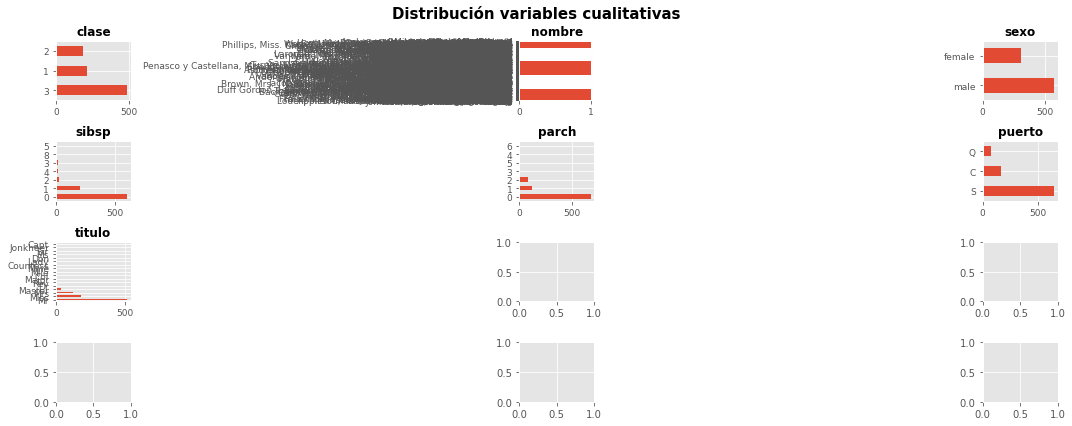

In [68]:
# Gráfico para cada variable cualitativa
# ==============================================================================

mask = train.drop(['ticket'], axis=1)

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 6))
axes = axes.flat
columnas_object = mask.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    mask[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
 
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 15, fontweight = "bold");

## <b>Ticket

In [ ]:
train['ticket'].value_counts()

## <b>Parch

Esta variable contiene observaciones que van desde 0 hasta el 6. En la que el valor 0: representa a los pasajeros que viajaron sin acompañantes; 1: acompañados por una persona; 2: acompañados por dos personas, y así sucesivamente.

In [ ]:
# Cantidad por acompañantes en parch
train.parch.value_counts()

In [ ]:
# Gráfica de supervivencia por acompañantes
plt.title("SUPERVIVENCIA POR ACOMPAÑANTES")
sns.countplot(x='parch', hue='vida', data=train)
plt.legend(['Fallecieron', 'Sobrevivieron'], loc='upper right')
plt.show()

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>📝 Note:</b> Hay muy pocas observaciones de pasajeros que no viajaron solos.
</div>

<div style="color:#21618C;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #AED6F1;
           background-color:#D6EAF8;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>💡 Idea:</b> Convertir las observaciones en valores binarios. Pasajeros que viajaron solos y pasajeros acompañados.
</div>

## <b> Clase



In [ ]:
# Visualización de distribución de clases
fig = plt.figure(figsize=(30,3))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("DISTRIBUCIÓN CLASE", fontsize=20)
ax1.set_title("SUPERVIVENCIA POR CLASE", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x="clase",data=train, ax=ax0, linewidth = 3).set(xlabel="Clase", ylabel="CANTIDAD")
sns.countplot(x="clase",data=train, ax=ax1, linewidth = 3, hue="vida").set(xlabel="Clases",ylabel="CANTIDAD")
fig.subplots_adjust(wspace=0.15)
plt.show()

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>📝 Note:</b> La mayoría de los pasajeros abordo viajaron en tercera clase, seguido por los de primera clase y segunda clase.
</div>

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>📝 Note:</b> La primera clase fue la única que registró un porcentaje de sobrevivientes mayor que de fallecidos, sin embargo, es notable la gran proporción de fallecidos que viajaron en tercera clase. Esta parece ser una variable de peso para inferir si un pasajero abordo sebrevivió o no.  
</div>

<b> 

## <b>Sexo

In [ ]:
# Visualización de distribución de sexo
# build figure
fig = plt.figure(figsize=(30,3))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("DISTRIBUCIÓN SEXO", fontsize=20)
ax1.set_title("SEXO / SUPERVIVENCIA", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x="sexo",data=train, ax=ax0, linewidth = 3).set(xlabel="SEXO", ylabel="CANTIDAD DE PASAJEROS")
sns.countplot(x="sexo",data=train, ax=ax1, linewidth = 3, hue="vida").set(xlabel="SEXO", ylabel="CANTIDAD DE PASAJEROS")
plt.legend(["fallecieron", "sobrevivieron"])
fig.subplots_adjust(wspace=0.25)
plt.show()

In [ ]:
# Porcentaje de supervivientes por sexo.
hombres_df = train[train['sexo']=='male']['vida']
mujeres_df = train[train['sexo']=='female']['vida']

print('El '+ str(round(len(hombres_df[hombres_df==1])*100/len(hombres_df),2)) +'% de los hombres sobrevivió.')
print('El '+ str(round(len(mujeres_df[mujeres_df==1])*100/len(mujeres_df),2)) +'% de los mujeres sobrevivió.')

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>💡 Idea:</b> Claramente se puede observar que gran porcentaje de las feminas sobrevivió (74%), en contraste, el porcentaje de los masculinos sobrevivientes fue muy bajo (19%).
</div>

## <b>Clase vs Sexo

In [ ]:
f_clase = train[train['sexo']=='female'][['clase', 'vida']]
m_clase = train[train['sexo']=='male'][['clase', 'vida']]

In [ ]:
# Visualización de distribución de sexo
# build figure
fig = plt.figure(figsize=(30,3))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("SUPERVIVENCIA FEMENINA", fontsize=20)
ax1.set_title("SUPERVIVENCIA MASCULINA", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x='clase', hue='vida', data=f_clase, ax=ax0).set(xlabel="SEXO", ylabel="CANTIDAD")
sns.countplot(x='clase', hue='vida', data=m_clase, ax=ax1).set(xlabel="SEXO", ylabel="CANTIDAD")
fig.subplots_adjust(wspace=0.25)
plt.show()

In [ ]:
# Unión de las variables sexo y clase
# ===========================================================================
train['clase_sexo'] = train['sexo'].map(str) +'_'+ train['clase'].map(str)
test['clase_sexo'] = test['sexo'].map(str) +'_'+ test['clase'].map(str)

# Eliminación de variables
# ===========================================================================
train.drop(['clase', 'sexo'], axis=1, inplace=True)
test.drop(['clase', 'sexo'], axis=1, inplace=True)

# <b>Puerto

In [ ]:
sns.countplot(x=train.puerto, hue=train.vida)
plt.show()

In [ ]:
sns.countplot(x='puerto', hue='clase', data=df_train)
plt.show()

# <b>PREPARE DATA

<b>Sólo utilizaré tres variables 3 variables como predictores.

In [ ]:
# Conjunto de datos de entrenamiento
X_train = train[['ticket', 'clase_sexo', 'tarifa']]
y_train = train.vida

# Conjunto de datos de prueba
X_test = test[['ticket', 'clase_sexo', 'tarifa']]

In [ ]:
num_features = X_train.select_dtypes(exclude='object').columns
cat_features = X_train.select_dtypes(include='object').columns

### <b>TRANSFORMADOR

In [ ]:
# Transformación de predictores
# =============================================================================

# numerical transformer pipeline (only contains 'tarifa')
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", RobustScaler()),
                           ])

# categorical transformer pipeline
cat_transformer = Pipeline([ 
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                            ])

transformer = ColumnTransformer([
    ('num_transfomer', num_transformer, num_features),
    ('cat_transformer', cat_transformer, cat_features),
                                ],remainder='passthrough')

X_prepared = transformer.fit_transform(X_train)

### <b>SELECCIÓN DE MODELO

In [ ]:
# Búsqueda del modelo con mejor puntaje
# ===================================================================================

models = {'svc': SVC(), 
          'logistic': LogisticRegression(),
          'random_forest': RandomForestClassifier(),
          'knn': KNeighborsClassifier()}

n_models = len(models)
scores=[]
for name, model in models.items():
    y_train_pred = cross_val_predict(model, X_prepared, y_train, cv=10)
    precision = np.mean(precision_score(y_train, y_train_pred)).round(2)
    recall = np.mean(recall_score(y_train, y_train_pred)).round(2)
    f1 = np.mean(f1_score(y_train, y_train_pred)).round(2)

    model_scores = np.array([name, precision, recall, f1])
    scores.append(np.array(model_scores))
          
scores_df = pd.DataFrame(scores, columns=['Model', 'Precision', 'Recall', 'F1']); scores_df.set_index('Model', inplace=True)
scores_df.sort_values(by='F1', ascending=False)

In [ ]:
# Reporte de puntuaciones del modelo Random Forest
# ==============================================================================
rforest_clf = RandomForestClassifier(random_state=42)
y_pred = cross_val_predict(rforest_clf, X_prepared, y_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

In [ ]:
# Área bajo la curva
# ================================================================================

y_scores = cross_val_predict(rforest_clf, X_prepared, y_train, cv=5, n_jobs=-1)
threshold = 0.5
y_with_thres = (y_scores > threshold)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
# Puntaje del area bajo la curva
# ============================================================================================
roc_auc_score(y_train, y_pred)

### <b>CONSTRUCCIÓN DEL MODELO (RANDOM FOREST)

In [ ]:
# Valores para hiperparámetros
# ===================================================================
# Cantidad de árboles
n_estimators = [int(x) for x in np.linspace(start=10, stop=500)]
# Cantidad de características a considerar en cada split
max_features = ['auto', 'sqrt', None]
# Máximo de niveles por árbol
max_depth = [int(x) for x in np.linspace(5, 50, num=45)]
max_depth.append(None)
# Mínimas muestras requeridad para dividir un nodo
min_samples_split = [2, 4, 6, 8, 10]
# Cantidad de muestras requeridas para cada hoja de nodo
min_samples_leaf = [1, 2, 4, 8, 10, 12, 14, 16, 20, 25, 30]
# Método de selección de muestras para entrenamiento en cada árbol
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Búsqueda aleatoria de hiperparámetros - RandomizedSearchCV
# ==============================================================================
rforest_classifier = RandomForestClassifier(random_state=23)
rf_random = RandomizedSearchCV(estimator=rforest_classifier, param_distributions=random_grid, n_iter=100, scoring='f1',
                               cv=3, random_state=123, n_jobs=-1,
                               return_train_score=False)

rf_random.fit(X_prepared, y_train)

In [ ]:
# Mejores hiperparámetros aleatorios
# ==============================================================================
rf_random.best_params_

In [ ]:
# Resultados de predicción del modelo con los mejores hiperparámetros aleatorios.
# ==============================================================================
rf_random = rf_random.best_estimator_
rf_random_pred = cross_val_predict(rf_random, X_prepared, y_train, cv=10, n_jobs=-1)
confusion_matrix(y_train, rf_random_pred)

In [ ]:
# Reporte de puntuaciones del modelo con los mejores hiperparámetros aleatorios.
# ==============================================================================
print(classification_report(y_train, rf_random_pred))

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
    <b>📝 Note:</b> Utilizando <b>F1-score</b> como métrica para evaluar el rendimiento del modelo, se puede apreciar un muy ligero incremento en la puntuación. 0.01 <b>(0.87)</b> para clase 0 y 0.01 <b>(0.75)</b> para clase 1.
</div>

#### <b>param_grid 

<b> Tomando como referencia los mejores parámetros arrojados por <b>RandomizedGridCV</b>, busco muevos parámetros que puedan mejor la precisión del modelo.

In [ ]:
param_grid = {
    'n_estimators': [200, 210, 220, 230, 240],
    'min_samples_split': [7, 8, 9],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None],
    'max_depth': [40, 45, 55, 60],
    'bootstrap': [True]
}

rforest_classifier2 = RandomForestClassifier(random_state=65)
grid_search = GridSearchCV(estimator=rforest_classifier2, param_grid =param_grid,
                           cv=3, n_jobs=-1, scoring='f1',
                           return_train_score=False)

grid_search.fit(X_prepared, y_train)

In [ ]:
# Mejores parámetros con GridSearch
# ==============================================================================
grid_search.best_params_

In [ ]:
# Resultados de predicción del modelo con los mejores parámetros GridSearchCV
# ==============================================================================
grid_search_model = grid_search.best_estimator_
grid_pred = cross_val_predict(grid_search_model, X_prepared, y_train, cv=10, n_jobs=-1)
confusion_matrix(y_train, grid_pred)

In [ ]:
# Reporte de puntuaciones del modelo Random Forest utilizando GridSearchCV
# ==============================================================================
print(classification_report(y_train, grid_pred))

Hubo una pequeña mejora para la clasificación de la clase 1 en un 0.01 (0.76) con el modelo <b>grid_model</b>.

In [ ]:
# Última búsqueda de parámetros
# ================================================================================
param_grid2 = {'bootstrap': [True],
 'max_depth': [38, 40, 42],
 'max_features': [None],
 'min_samples_leaf': [1],
 'min_samples_split': [7],
 'n_estimators': [205, 210, 215]}

rforest_classifier3 = RandomForestClassifier(random_state=12)
grid_search2 = GridSearchCV(estimator=rforest_classifier3, param_grid =param_grid2,
                           cv=3, n_jobs=-1, scoring='f1',
                           return_train_score=False)

grid_search2.fit(X_prepared, y_train)

In [ ]:
grid_search2.best_params_

In [ ]:
# Resultados de predicción del modelo con los mejores parámetros GridSearchCV
# ==============================================================================
grid_search_model2 = grid_search2.best_estimator_
grid_pred2 = cross_val_predict(grid_search_model2, X_prepared, y_train, cv=10, n_jobs=-1)
confusion_matrix(y_train, grid_pred2)

In [ ]:
# Reporte de puntuaciones del modelo Random Forest utilizando GridSearchCV
# ==============================================================================
print(classification_report(y_train, grid_pred2))

No hubo mejoras en la capacidad de predicción sobre el modelo anterior. Tomo este como modelo final.

In [ ]:
final_model = grid_search_model2

# <b>PREDICCIÓN

In [ ]:
# Transformación de los predictores en el conjunto de datos de prueba
test_prepared = transformer.transform(X_test)

In [ ]:
# Predicciones
# ====================================================================================
predictions = final_model.predict(test_prepared)

In [ ]:
test['vida'] = predictions
titanic_preds = test[['id', 'vida']]
titanic_preds.columns=['PassengerId', 'Survived']
titanic_preds.to_csv('submission2.csv',index=False)

In [ ]:
# Resultados de predicciones
# =====================================================================================
titanic_preds